# MSDS 7331 - Mini Lab: Logistic Regression and SVMs

### Investigators
- [Matt Baldree](mailto:mbaldree@smu.edu?subject=mini-lab)
- [Tom Elkins](telkins@smu.edu?subject=mini-lab)
- [Austin Kelly](ajkelly@smu.edu?subject=mini-lab)
- [Murali Parthasarathy](mparthasarathy@smu.edu?subject=mini-lab)


<div style='margin-left:10%;margin-right:10%;margin-top:15px;background-color:#d3d3d3;padding:5px;'>
    <h3>Lab Instructions</h3>
    <p>You are to perform predictive analysis (classification) upon a data set: model the dataset using methods we have discussed in class: logistic regression and support vector machines, and making conclusions from the analysis. Follow the CRISP-DM framework in your analysis (you are not performing all of the CRISP-DM outline, only the portions relevant to the grading rubric outlined below). This report is worth 10% of the final grade. You may complete this assignment in teams of as many as three people.
Write a report covering all the steps of the project. The format of the document can be PDF, *.ipynb, or HTML. You can write the report in whatever format you like, but it is easiest to turn in the rendered iPython notebook. The results should be reproducible using your report. Please carefully describe every assumption and every step in your report.</p>
</div>

## 1 - Background
We continue our data science work on the 2015 Washington, D.C. Metro Crime data as refined in Lab 1. This dataset contains crime data specified as "OFFENSE". An offense code was established for each offense and the offense were grouped into a binary classification of property or violent crime. The number used for the code does not imply a level of severity they were simply applied in order of appearance). The table below provides a mapping of the textual offense to its code and type of crime.

|Offense|Offense_Code|Crime_Type|
|:------|:----------:|---------:|
|Theft/Other|1|2 (Property)|
|Theft from Auto|2|2 (Property)|
|Burglary|3|2 (Property)|
|Assault with Dangerous Weapon|4|1 (Violent)|
|Robbery|5|1 (Violent)|
|Motor Vehicle Theft|6|2 (Property)|
|Homicide|7|1 (Violent)|
|Sex Abuse|8|1 (Violent)|
|Arson|9|2 (Property)|

The dataset also contains a variety of geographic identifiers representing different political, social, and legal boundaries.

- DISTRICT -- the Police district within which the crime was committed
- Police Service Area (PSA) -- A subordinate area within a District
- Ward -- A political area, similar to a "county" in a larger state
- Advisory Neighborhood Committed (ANC) -- A social group consisting of neighbors and social leaders in a small geographic area
- Voting Precinct -- A political area for the management of voting residents
- Local Coordinates (XBLOCK and YBLOCK) -- location within the DC metro area based on the Maryland mapping system
- Global Coordinates (Latitude and Longitude) -- location on the planet

The dataset also contains time-based identifiers.
- The Start and End dates/times of when the crime *might* have been committed.
- The date/time the crime was reported (i.e. when the police responded and took the report)
- Shift - the police duty shift that responded to the crime (broken into 8-hour periods within a day)

# 2 - Predictive Analysis Goal
This mini-lab will predict a classification for the OFFENSE code and CRIME_TYPE given a set of features. Two classification models will be used to perform this classification - 1) logistic regression and 2) support vector machine (SVM). Parameters for these algorithms will be adjusted to determine the setting that yields the most accurate results. 

### Crime_Type (Violent/Property)
The first classification task is a binary classification, in which we attempt to build a model to predict whether the crime will be against a person (violent) or against property given the other features of the data (geographic location, time of day, political area, etc.). The goal is to help the Police manage resources more appropriately.

### Offense/Offense_Code
For the second classification task, we chose to attempt building a model to predict the type of offense (theft, homicide, assault, arson, etc.).  The hope is that if a type of crime could be predicted, then the Police would be better able to allocate offense-specific resources appropriately.

### Model Comparison
Secondarily, we seek to compare the accuracy of the models - i.e. if the Crime_Type prediction indicates a "Violent" crime, does the Offense prediction agree (Homicide, Sex Abuse, Robbery, or Assault).

# 3 - Modeling

<div style='margin-left:10%;margin-right:10%;margin-top:15px;background-color:#d3d3d3;padding:10px;'>
    <ol><li>[<b>50 points</b>] Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use.</li>
</ol>
</div>

## 3.1 Data Preparation
Our dataset must be prepared for `scikit-learn` library of classifiers.

### 3.1.1 Load Data

In [60]:
import pandas as pd
import numpy as np
from __future__ import print_function

# plotting stuff
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import seaborn as sns
sns.set(font_scale=1)
cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings

# Read in the crime data from the Lab 1 CSV file
dc = pd.read_csv('data/DC_Crime_2015_Lab1.csv')

In [61]:
# remind ourselves about the columns we have in this dataset
dc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36489 entries, 0 to 36488
Data columns (total 26 columns):
REPORT_DAT              36489 non-null object
SHIFT                   36489 non-null object
OFFENSE                 36489 non-null object
METHOD                  36489 non-null object
DISTRICT                36442 non-null float64
PSA                     36441 non-null float64
WARD                    36489 non-null int64
ANC                     36489 non-null int64
NEIGHBORHOOD_CLUSTER    36489 non-null int64
CENSUS_TRACT            36489 non-null int64
VOTING_PRECINCT         36489 non-null int64
CCN                     36489 non-null int64
XBLOCK                  36489 non-null float64
YBLOCK                  36489 non-null float64
START_DATE              36489 non-null object
END_DATE                36489 non-null object
PSA_ID                  36489 non-null int64
DistrictID              36489 non-null int64
SHIFT_Code              36489 non-null int64
OFFENSE_Code          

### 3.1.2 Break crime start date into usable values for prediction

In [62]:
# convert START_DATE to datetime
dc.START_DATE = pd.to_datetime(dc.START_DATE)

# add the month of the crime
dc['Crime_Start_Month'] = dc["START_DATE"].map(lambda x: x.month)
dc.Crime_Start_Month = dc.Crime_Start_Month.astype('int64')

# add day of the month
dc['Crime_Start_Day'] = dc["START_DATE"].map(lambda x:x.day)
dc.Crime_Start_Day = dc.Crime_Start_Day.astype('int64')

# add hour of the day
dc['Crime_Start_Hour'] = dc["START_DATE"].map(lambda x:x.hour)
dc.Crime_Start_Hour = dc.Crime_Start_Hour.astype('int64')

In [63]:
# printout offenses and codes for reference
print(dc.OFFENSE.unique())
print(dc.OFFENSE_Code.unique())

# printout crime type for reference - 1:violent, 2:property
print(dc.CRIME_TYPE.unique())

['THEFT/OTHER' 'THEFT F/AUTO' 'BURGLARY' 'ASSAULT W/DW' 'ROBBERY'
 'MOTOR VEHICLE THEFT' 'HOMICIDE' 'SEX ABUSE' 'ARSON']
[1 2 3 4 5 6 7 8 9]
[2 1]


### 3.1.3 Remove redundant features

In [64]:
# set new dataframe to use for classification; might need existing columns for later analysis
#df_classify = dc.copy()
df_classify = dc

# remove attributes that are redundant with other attributes
# most redundant because of Codes
# TIME_TO_REPORT is redundant with AGE
# XBLOCK and YBLOCK redundant with latitude and longitude
for attrib in ('OFFENSE', 'METHOD', 'DISTRICT', 'REPORT_DAT', 'CCN', 'START_DATE', 'END_DATE', 
               'SHIFT', 'PSA', 'TIME_TO_REPORT', 'XBLOCK', 'YBLOCK'):
    if attrib in df_classify:
        del df_classify[attrib]

### 3.1.4 Remove features we don't care about

In [65]:
# we are interested in police service area, remove all other geogrpahic features
for attrib in ('PSA_ID', 'ANC', 'NEIGHBORHOOD_CLUSTER', 'DistrictID', 'CENSUS_TRACT', 'VOTING_PRECINCT', 'AGE',
              'Crime_Start_Month', 'Crime_Start_Day'):
    if attrib in df_classify:
        del df_classify[attrib]

In [66]:
df_classify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36489 entries, 0 to 36488
Data columns (total 8 columns):
WARD                36489 non-null int64
SHIFT_Code          36489 non-null int64
OFFENSE_Code        36489 non-null int64
METHOD_Code         36489 non-null int64
CRIME_TYPE          36489 non-null int64
Latitude            36489 non-null float64
Longitude           36489 non-null float64
Crime_Start_Hour    36489 non-null int64
dtypes: float64(2), int64(6)
memory usage: 2.2 MB


### 3.1.5 Break categories into separate columns for each possible outcome.

In [67]:
# perform one-hot encoding of non-binary categorical data

for attrib in ('SHIFT_Code', 'METHOD_Code', 'WARD'):
    tmp_df = pd.get_dummies(df_classify[attrib], prefix=attrib)
    df_classify = pd.concat((df_classify, tmp_df),axis=1) # add back into the dataframe
    
    del df_classify[attrib] # remove attribe

print(df_classify.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36489 entries, 0 to 36488
Data columns (total 19 columns):
OFFENSE_Code        36489 non-null int64
CRIME_TYPE          36489 non-null int64
Latitude            36489 non-null float64
Longitude           36489 non-null float64
Crime_Start_Hour    36489 non-null int64
SHIFT_Code_1        36489 non-null uint8
SHIFT_Code_2        36489 non-null uint8
SHIFT_Code_3        36489 non-null uint8
METHOD_Code_1       36489 non-null uint8
METHOD_Code_2       36489 non-null uint8
METHOD_Code_3       36489 non-null uint8
WARD_1              36489 non-null uint8
WARD_2              36489 non-null uint8
WARD_3              36489 non-null uint8
WARD_4              36489 non-null uint8
WARD_5              36489 non-null uint8
WARD_6              36489 non-null uint8
WARD_7              36489 non-null uint8
WARD_8              36489 non-null uint8
dtypes: float64(2), int64(3), uint8(14)
memory usage: 1.9 MB
None


## 3.2 - Dataset Review
### 3.2.1 Now it is time to review our data before modeling it. We will begin by displaying simple statistics of our columns.

In [68]:
df_classify.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
OFFENSE_Code,36489.0,2.468634,1.717339,1.000000,1.00000,2.000000,3.000000,9.000000
CRIME_TYPE,36489.0,1.830826,0.374911,1.000000,2.00000,2.000000,2.000000,2.000000
Latitude,36489.0,38.907139,0.030849,38.813471,38.89208,38.906455,38.926422,38.993560
Longitude,36489.0,-77.008059,0.035893,-77.113642,-77.03196,-77.012929,-76.985512,-76.910021
Crime_Start_Hour,36489.0,13.517526,6.394569,0.000000,9.00000,14.000000,19.000000,23.000000
SHIFT_Code_1,36489.0,0.372140,0.483382,0.000000,0.00000,0.000000,1.000000,1.000000
SHIFT_Code_2,36489.0,0.437885,0.496134,0.000000,0.00000,0.000000,1.000000,1.000000
SHIFT_Code_3,36489.0,0.189975,0.392287,0.000000,0.00000,0.000000,0.000000,1.000000
METHOD_Code_1,36489.0,0.908356,0.288527,0.000000,1.00000,1.000000,1.000000,1.000000
METHOD_Code_2,36489.0,0.059717,0.236964,0.000000,0.00000,0.000000,0.000000,1.000000


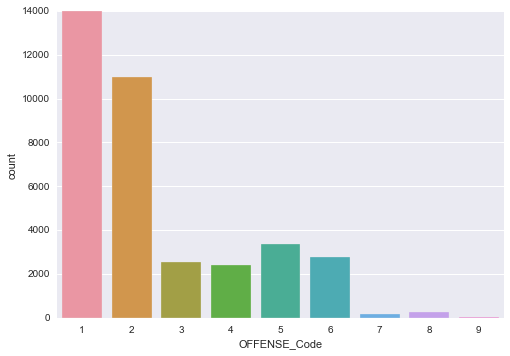

In [69]:
# 1: Theft/Other, 2: Theft from Auto, 3: Burglary, 4: Assault with Dangerous Weapon,
# 5: Robbery, 6: Motor Vehicle Theft, 7: Homicide, 8: Sex Abuse, 9: Arson

tmpdf = df_classify[['OFFENSE_Code']]
sns.countplot(x='OFFENSE_Code', data=tmpdf)

Offence Code 1 or Theft/Other is 38% of our population. We are imbalanced with offense code 1 and 2.

In [70]:
df_classify.OFFENSE_Code.value_counts() / len(df_classify.OFFENSE_Code) * 1.

1    0.383677
2    0.300639
5    0.091863
6    0.076571
3    0.069446
4    0.065499
8    0.007482
7    0.004330
9    0.000493
Name: OFFENSE_Code, dtype: float64

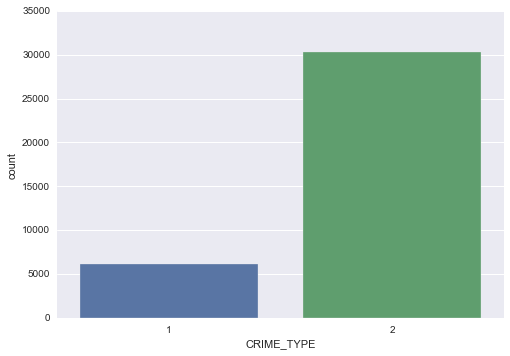

In [71]:
# 1: violent, 2: propery

tmpdf = df_classify[['CRIME_TYPE']]
sns.countplot(x='CRIME_TYPE', data=tmpdf)

Property crime type is 83% of our population. This means we have an imbalanced class data.

In [72]:
df_classify.CRIME_TYPE.value_counts() / len(df_classify.CRIME_TYPE) * 1.

2    0.830826
1    0.169174
Name: CRIME_TYPE, dtype: float64

## 3.3 - Training and Testing Split

For training and testing purposes, let's gather the data we have and grab 80% of the instances for training and the remaining 20% for testing. Moreover, let's repeat this process of separating the testing and training data three times. We will use the hold out cross validation method built into `scikit-learn`.

In [73]:
crime_type_target = 'CRIME_TYPE'
offense_code_target = 'OFFENSE_Code'

features = df_classify.columns.values
features = features[(features != 'CRIME_TYPE') & (features != 'OFFENSE_Code')]
print('number of features =', len(features))

y_crime_type = df_classify[crime_type_target].values
y_offense_code = df_classify[offense_code_target].values

X = df_classify[features].values
print(X.shape)

number of features = 17
(36489, 17)


In [74]:
from sklearn.model_selection import StratifiedShuffleSplit
    
    
# to use the cross validation object in scikit-learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
cv_object = StratifiedShuffleSplit(n_splits=3, test_size=0.2)
print(cv_object)

StratifiedShuffleSplit(n_splits=3, random_state=None, test_size=0.2,
            train_size=None)


## 3.4 Normalization

In [75]:
# let's normalize our data
from sklearn.preprocessing import StandardScaler

# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , X_test

for train_indices, test_indices in cv_object.split(X, y_crime_type):
    X_train = X[train_indices]

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_norm = scl_obj.transform(X)

In [76]:
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

## 3.5 Logistic Regression

### 3.5.1 Crime Type Classification

In [77]:
# http://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html
C_range = np.logspace(-2, 3, 4)
param_grid = dict(C=C_range)
cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)

grid = GridSearchCV(LogisticRegression(penalty='l2', class_weight='balanced', multi_class='ovr', n_jobs=-1), 
                    param_grid=param_grid, cv=cv)
grid.fit(X_norm, y_crime_type)

print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 0.01} with a score of 0.85


In [78]:
# use best model and report
lgr = LogisticRegression(penalty='l2', class_weight='balanced', multi_class='ovr', n_jobs=-1, C=.01)
cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)

iter_num = 0
for train_indices, test_indices in cv.split(X_norm, y_crime_type):
    %timeit lgr.fit(X_norm[train_indices], y_crime_type[train_indices])  # train object
    y_hat = lgr.predict(X_norm[test_indices]) # get test set predictions
    
    iter_num = iter_num + 1
    print('Iteration: ', iter_num)
    print(accuracy_score(y_crime_type[test_indices], y_hat))
    print(classification_report(y_crime_type[test_indices], y_hat))

10 loops, best of 3: 135 ms per loop
Iteration:  1
0.853795560428
             precision    recall  f1-score   support

          1       0.56      0.66      0.60      1235
          2       0.93      0.89      0.91      6063

avg / total       0.87      0.85      0.86      7298

10 loops, best of 3: 132 ms per loop
Iteration:  2
0.857495204166
             precision    recall  f1-score   support

          1       0.57      0.63      0.60      1235
          2       0.92      0.90      0.91      6063

avg / total       0.86      0.86      0.86      7298

10 loops, best of 3: 117 ms per loop
Iteration:  3
0.842011510003
             precision    recall  f1-score   support

          1       0.53      0.65      0.58      1235
          2       0.93      0.88      0.90      6063

avg / total       0.86      0.84      0.85      7298



Coefficients

In [79]:
# sort these attributes and spit them out
zip_vars = zip(lgr.coef_.T, features) # combine attributes
zip_vars.sort(key = lambda t: np.abs(t[0]), reverse=True) # sort them by the magnitude of the weight
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

METHOD_Code_1 has weight of 0.812496140314
METHOD_Code_2 has weight of -0.622841041611
METHOD_Code_3 has weight of -0.493986797303
SHIFT_Code_3 has weight of -0.332128517694
SHIFT_Code_1 has weight of 0.308971422087
WARD_2 has weight of 0.179996351573
WARD_3 has weight of 0.173876757694
WARD_4 has weight of -0.10046383732
WARD_8 has weight of -0.0901039811674
Longitude has weight of -0.082078786359
WARD_7 has weight of -0.0795978827195
Latitude has weight of 0.0639458463094
WARD_1 has weight of -0.0396485052708
SHIFT_Code_2 has weight of -0.0387151161018
WARD_5 has weight of -0.0261908204984
Crime_Start_Hour has weight of 0.0154925600639
WARD_6 has weight of -0.00331575393164


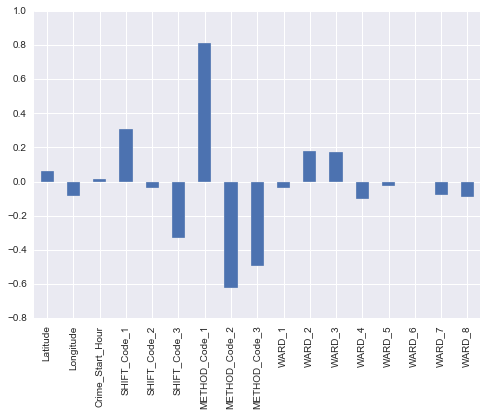

In [80]:
# now let's make a pandas Series with the names and values, and plot them
weights = pd.Series(lgr.coef_[0], index=features)
#sns.barplot(y=weights, x=weights.index, data=weights)
weights.plot(kind='bar')
#plt.xlabel('features', fontsize=5)
plt.show()

# method_code = 'others':1, 'gun':2, 'knife':3

### 3.5.2 Offense Codes Classification

In [81]:
# use best model and report
lgr = LogisticRegression(penalty='l2', class_weight='balanced', multi_class='multinomial',
                                      solver='sag', n_jobs=-1, C=100, max_iter=500)
cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)

iter_num = 0
for train_indices, test_indices in cv.split(X_norm, y_offense_code):
    %timeit lgr.fit(X_norm[train_indices], y_offense_code[train_indices])  # train object
    y_hat = lgr.predict(X_norm[test_indices]) # get test set predictions
    
    iter_num = iter_num + 1
    print('Iteration: ', iter_num)
    print(accuracy_score(y_offense_code[test_indices], y_hat))
    print(classification_report(y_offense_code[test_indices], y_hat))

1 loop, best of 3: 17.4 s per loop
Iteration:  1
0.233351603179
             precision    recall  f1-score   support

          1       0.49      0.21      0.29      2800
          2       0.40      0.28      0.33      2194
          3       0.05      0.03      0.04       507
          4       0.46      0.40      0.43       478
          5       0.11      0.24      0.15       670
          6       0.15      0.17      0.16       559
          7       0.13      0.66      0.22        32
          8       0.01      0.22      0.03        55
          9       0.00      0.33      0.00         3

avg / total       0.36      0.23      0.27      7298

1 loop, best of 3: 17.5 s per loop
Iteration:  2
0.291997807619
             precision    recall  f1-score   support

          1       0.53      0.20      0.29      2800
          2       0.41      0.43      0.42      2194
          3       0.09      0.20      0.13       507
          4       0.38      0.44      0.41       478
          5       0.

## 3.6 Support Vector Machine (SVM) Regression

In [82]:
# run logistic regression and vary some parameters
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

### 3.6.1 Crime Type Classification

In [83]:
C_range = np.logspace(-2, 3, 4)
param_grid = dict(C=C_range)

cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
grid = GridSearchCV(LinearSVC(penalty='l2', multi_class='ovr', class_weight='balanced', dual=True), 
                    param_grid=param_grid, cv=cv, n_jobs=-1)
grid.fit(X_norm, y_crime_type)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 21.544346900318846} with a score of 0.87


In [84]:
# use best model and report
svm = LinearSVC(penalty='l2', class_weight='balanced', dual=True, multi_class='ovr', C=21.5)
cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)

iter_num = 0
for train_indices, test_indices in cv.split(X_norm, y_crime_type):
    %timeit svm.fit(X_norm[train_indices], y_crime_type[train_indices])  # train object
    y_hat = svm.predict(X_norm[test_indices]) # get test set precitions
    
    iter_num = iter_num + 1
    print('Iteration: ', iter_num)
    print(accuracy_score(y_crime_type[test_indices], y_hat))
    print(classification_report(y_crime_type[test_indices], y_hat))

1 loop, best of 3: 5.09 s per loop
Iteration:  1
0.921074266922
             precision    recall  f1-score   support

          1       0.99      0.54      0.70      1235
          2       0.91      1.00      0.95      6063

avg / total       0.93      0.92      0.91      7298

1 loop, best of 3: 5.2 s per loop
Iteration:  2
0.867909016169
             precision    recall  f1-score   support

          1       0.62      0.58      0.60      1235
          2       0.92      0.93      0.92      6063

avg / total       0.87      0.87      0.87      7298

1 loop, best of 3: 6.29 s per loop
Iteration:  3
0.851466155111
             precision    recall  f1-score   support

          1       0.56      0.55      0.56      1235
          2       0.91      0.91      0.91      6063

avg / total       0.85      0.85      0.85      7298



[[-0.07517159  0.04921679 -0.1419031   0.11642787 -0.05839674 -0.06972371
   0.20637508 -0.15585682 -0.12866833  0.02198495 -0.09527489 -0.10933965
   0.09397508  0.09772674 -0.0565024   0.03753847  0.00076474]]


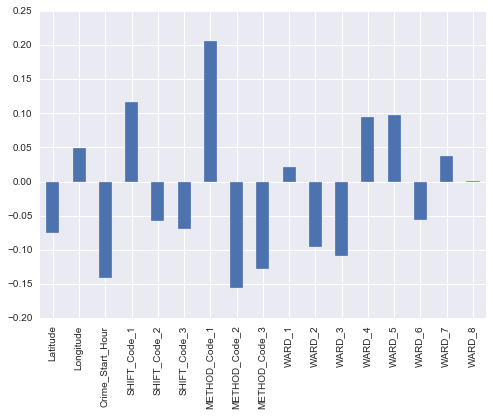

In [85]:
print(svm.coef_)
weights = pd.Series(svm.coef_[0],index=features)
weights.plot(kind='bar')

### LinearSVC doesn't provide access to support vectors. Therefore, we use SVC algorithm to get the appropriate result attribute.

In [86]:
# use best model and report
svm = SVC(kernel='linear', gamma='auto', cache_size=2000, class_weight='balanced', 
          decision_function_shape='ovr', C=21.5, max_iter=500, shrinking=True)
cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)

iter_num = 0
for train_indices, test_indices in cv.split(X_norm, y_crime_type):
    %timeit svm.fit(X_norm[train_indices], y_crime_type[train_indices])  # train object
    y_hat = svm.predict(X_norm[test_indices]) # get test set precitions
    
    iter_num = iter_num + 1
    print('Iteration: ', iter_num)
    print(accuracy_score(y_crime_type[test_indices], y_hat))
    print(classification_report(y_crime_type[test_indices], y_hat))

1 loop, best of 3: 407 ms per loop
Iteration:  1
0.476842970677
             precision    recall  f1-score   support

          1       0.19      0.67      0.30      1235
          2       0.87      0.44      0.58      6063

avg / total       0.75      0.48      0.53      7298

1 loop, best of 3: 445 ms per loop
Iteration:  2
0.709509454645
             precision    recall  f1-score   support

          1       0.31      0.57      0.40      1235
          2       0.89      0.74      0.81      6063

avg / total       0.79      0.71      0.74      7298

1 loop, best of 3: 421 ms per loop
Iteration:  3
0.831049602631
             precision    recall  f1-score   support

          1       0.50      0.55      0.52      1235
          2       0.91      0.89      0.90      6063

avg / total       0.84      0.83      0.83      7298



In [87]:
# look at the support vectors
print(svm.support_vectors_.shape)
print(svm.support_.shape)
print(svm.n_support_ )

(518, 17)
(518,)
[156 362]


In [88]:
# Now let's do some different analysis with the SVM and look at the instances that were chosen as support vectors

# now lets look at the support for the vectors and see if we they are indicative of anything
# grabe the rows that were selected as support vectors (these are usually instances that are hard to classify)

# make a dataframe of the training data
df_tested_on = df_classify.iloc[train_indices] # saved from above, the indices chosen for training
# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm.support_,:]

df_support['Crime_Type'] = y_crime_type[svm.support_] # add back in the 'Survived' Column to the pandas dataframe
df_classify['Crime_Type'] = y_crime_type # also add it back in for the original data
df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 518 entries, 21184 to 29797
Data columns (total 20 columns):
OFFENSE_Code        518 non-null int64
CRIME_TYPE          518 non-null int64
Latitude            518 non-null float64
Longitude           518 non-null float64
Crime_Start_Hour    518 non-null int64
SHIFT_Code_1        518 non-null uint8
SHIFT_Code_2        518 non-null uint8
SHIFT_Code_3        518 non-null uint8
METHOD_Code_1       518 non-null uint8
METHOD_Code_2       518 non-null uint8
METHOD_Code_3       518 non-null uint8
WARD_1              518 non-null uint8
WARD_2              518 non-null uint8
WARD_3              518 non-null uint8
WARD_4              518 non-null uint8
WARD_5              518 non-null uint8
WARD_6              518 non-null uint8
WARD_7              518 non-null uint8
WARD_8              518 non-null uint8
Crime_Type          518 non-null int64
dtypes: float64(2), int64(4), uint8(14)
memory usage: 35.4 KB


/Users/mattbaldree/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


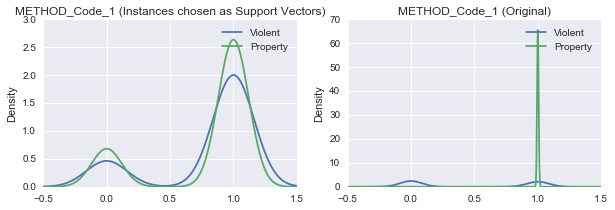

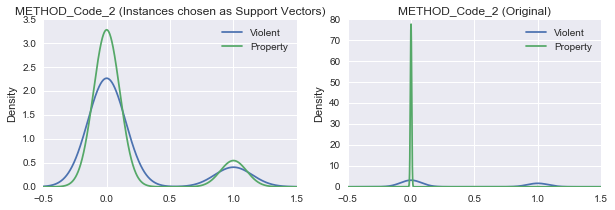

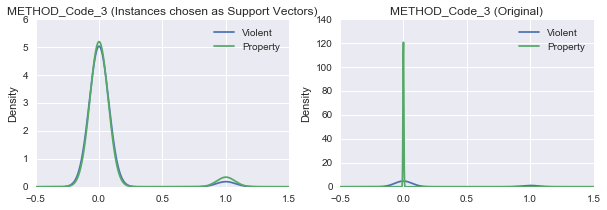

In [89]:
# now lets see the statistics of these attributes
from pandas.tools.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['Crime_Type'])
df_grouped = df_classify.groupby(['Crime_Type'])

# plot KDE of Different variables
vars_to_plot = ['METHOD_Code_1', 'METHOD_Code_2', 'METHOD_Code_3']

for v in vars_to_plot:
    plt.figure(figsize=(10,3))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['Violent','Property'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['Violent','Property'])
    plt.title(v+' (Original)')

In [98]:
df_grouped_support['METHOD_Code_1'].mean()

Crime_Type
1    0.811765
2    0.794457
Name: METHOD_Code_1, dtype: float64

In [107]:
df_grouped_support['METHOD_Code_1'][1 == 0]

Exception: Column(s) METHOD_Code_1 already selected

In [106]:
x1 = df_grouped_support['METHOD_Code_1']
y1 = 

In [ ]:
# http://stackoverflow.com/questions/31539815/plotting-two-distributions-in-seaborn-jointplot
df1 = df_grouped_support['METHOD_Code_1']
df2 = df_grouped['METHOD_Code_1']

g = sns.jointplot(x=df1, y=df1[0], color='r')

g.x = df2.x2
g.y = df2.y2
g.plot_joint(plt.scatter, marker='x', c='b', s=50)

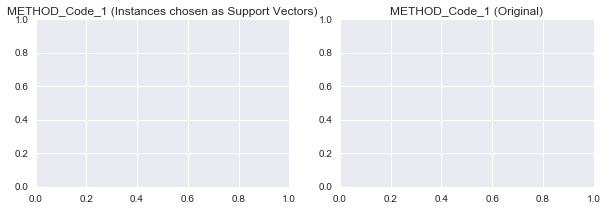

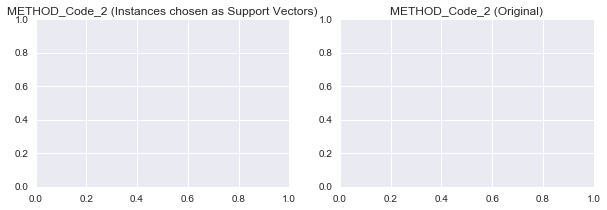

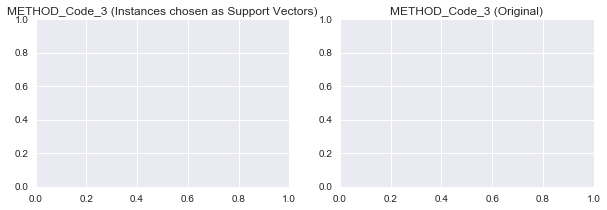

In [103]:
for v in vars_to_plot:
    plt.figure(figsize=(10,3))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot 
    
    plt.legend(['Violent','Property'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot
    plt.legend(['Violent','Property'])
    plt.title(v+' (Original)')

### 3.6.2 Offense Code Classification

In [26]:
# use best model and report
svm = LinearSVC(penalty='l2', class_weight='balanced', dual=True, multi_class='ovr', C=21.5)
cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)

iter_num = 0
for train_indices, test_indices in cv_object.split(X_norm, y_offense_code):
    %timeit svm.fit(X_norm[train_indices], y_crime_type[train_indices])  # train object
    y_hat = svm.predict(X_norm[test_indices]) # get test set precitions
    
    iter_num = iter_num + 1
    print('Iteration: ', iter_num)
    print(accuracy_score(y_offense_code[test_indices], y_hat))
    print(classification_report(y_offense_code[test_indices], y_hat))

1 loop, best of 3: 4.93 s per loop
Iteration:  1
0.301726500411
             precision    recall  f1-score   support

          1       0.01      0.00      0.01      2800
          2       0.33      1.00      0.50      2194
          3       0.00      0.00      0.00       507
          4       0.00      0.00      0.00       478
          5       0.00      0.00      0.00       670
          6       0.00      0.00      0.00       559
          7       0.00      0.00      0.00        32
          8       0.00      0.00      0.00        55
          9       0.00      0.00      0.00         3

avg / total       0.10      0.30      0.15      7298



/Users/mattbaldree/anaconda/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1 loop, best of 3: 5 s per loop
Iteration:  2
0.322280076733
             precision    recall  f1-score   support

          1       0.24      0.14      0.17      2800
          2       0.34      0.90      0.50      2194
          3       0.00      0.00      0.00       507
          4       0.00      0.00      0.00       478
          5       0.00      0.00      0.00       670
          6       0.00      0.00      0.00       559
          7       0.00      0.00      0.00        32
          8       0.00      0.00      0.00        55
          9       0.00      0.00      0.00         3

avg / total       0.20      0.32      0.22      7298

1 loop, best of 3: 6.5 s per loop
Iteration:  3
0.2984379282
             precision    recall  f1-score   support

          1       0.02      0.00      0.01      2800
          2       0.33      0.99      0.49      2194
          3       0.00      0.00      0.00       507
          4       0.00      0.00      0.00       478
          5       0.00    

[[ 0.00179044 -0.04993033 -0.05292161  0.07361695  0.02147665 -0.1180778
   0.26995305 -0.20501657 -0.1666266  -0.0017194  -0.01095976  0.07364931
  -0.09812445 -0.01401438  0.01532216  0.06367137 -0.01349518]]


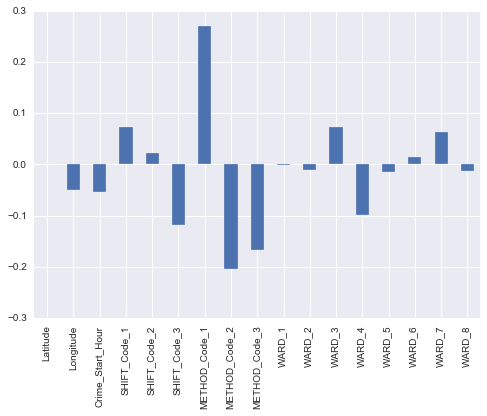

In [27]:
print(svm.coef_)
weights = pd.Series(svm.coef_[0],index=features)
weights.plot(kind='bar')

# 4 - Discuss advanges of each model for each classification task.

<div style='margin-left:10%;margin-right:10%;margin-top:15px;background-color:#d3d3d3;padding:10px;'>
    <ol><li>[<b>10 points</b>]  Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.</li>
</ol>
</div>

## 1.1 Advantages and Disadvantages of Logistic Regression

## 1.2 Advantages and Disadvantages of Support Vector Machine (SVM)

An advantage of SVM is that the algorithm is effective in high dimensional space where features outnumber samples. The algorithm uses a subset of training points (support vectors) in the decision function making the algorithm more memory efficient than others. In addition, the algorihm allows for different kernel functions to be specified for the decision function. `scikit-learn` provides three kernels with its SVC algorithm.

SVC supports three kernel functions; i.e., linear, polynomial, and radial. Examples of these three kernel functions and the boundaries they produced are shown below. This flexibility allows the data scientist to better tune the model to the problem. In addition, a cost control parameter is provided allowing the modeler to indicate how outlier data should be penalized creating an appropriate soft margin for the decision boundary or hyperplane. Finally, a gamma parameter is provided allowing the modeler to control the curvature of the hyperplane.  

In addition, over-fitting is not common with SVM.  It works well with fewer training samples, and its prediction accuracy is generally high. Once the model is fitted or learnt, the evaluation of new data is fast.

![SVM Kernels](images/svm_kernels.png "SVM Kernels")

A main disadvantage of SVM is the quadratic requirement in compute and storage for large-scale tasks, see below for more details. This makes training a SVM painful. Another disadvantage is the time it takes to determine the optimal settings for cost, gamma, and kernel function. Finally, the weights can be difficult to interpret.


## 1.3 Performance

`scikit-learn's` Linear SVC algorithm used to classify CRIME_TYPE provided an improved accuracy of 6% over Logistic Regression algorithm, 91% accuracy versus 85%. But, the Logistic Regression algorithm was able to fit or train a model 34.6 times faster than Linear SVC (4.12s / 119 ms). While this difference is substantial, it is much better than the generic SVC algorithm. 

The reason for the learning time discrepency is that `scikit-learn's` generic SVC algorithm is based a different underlying C SVM engine than LinearSVC. SVC's engine requires increasing (quadratic) compute and storage requirements as the number of its training vectors grow. On the otherhand, Linear SVC is far more efficient and can scale to millions of samples and/or features. 

# 5 - Interpret the weights

<div style='margin-left:10%;margin-right:10%;margin-top:15px;background-color:#d3d3d3;padding:10px;'>
    <ol>
    <li>[<b>30 points</b>] Use the weights from logistic regression to interpret the importance of different features for each classification task. Explain your interpretation in detail. Why do you think some variables are more important?</li>
</ol>
</div>

# 6 - Analyze the support vectors

<div style='margin-left:10%;margin-right:10%;margin-top:15px;background-color:#d3d3d3;padding:10px;'>
    <ol>
    <li>[<b>10 points</b>]  Look at the chosen support vectors for the classification task. Do these provide
any insight into the data? Explain.</li>
</ol>
</div>

Support vectors are the datapoints that define the hyperplane. Kernel functions allow the algorithm to map to a higher dimension (infinite) allowing for separation. Fitting `scikit-learn's` SVC algorithm for the Crime Type problem provided the following support vectors:

- Support Vectors = (528, 17)
528 support vectors were chosen out of 36,489 records. Each support vector has a weight associated with each feature (17). 

- Support Vector Indices = (528,)
The row in the dataset that was chosen as a support vector.

- Support Vectors for Each Class = [160 368]
Violent Crimes has 160 support vectors and Property Crimes has 368. These vectors provide the coordinates for the hyperplane or decision function to classify or predict a crime as violent or property type.